# Sentiment Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Regex
import re 

# NLTK
import nltk #for text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import  MultinomialNB
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV


# Experiments done
- Changed preprocessing method
    - (`preprocess_v1`) Did not remove following words after @ and #
    - (`preprocess_v2`) Removed following words after @ and #
    - (`preprocess_v3`) Used spaCy
    - Compare performance of preprocessing function vs perfomance of spaCy
- Compared performance between different models
- Hyperparameter tuning: GridSearch CV


# Data Preprocessing
This section of the notebook presents the preprocessing done to the dataset.

In [2]:
def txt_to_df(file_path):
    """
    This function converts the dataset from text files to dataframe.
    
    Parameters:
        file_path (str): Path of the dataset.
    Returns:
        df: Pandas dataframe.
    """
    # Initialize empty lists to hold the columns
    tweet_ids = []
    sentiments = []
    tweet_texts = []

    # Read the file line by line and split by tabs to populate the lists
    with open(file_path, 'r', encoding='unicode-escape') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Only consider lines with all three components
                tweet_ids.append(parts[0])
                sentiments.append(parts[1])
                tweet_texts.append(parts[2])

    # Create the DataFrame using the populated lists
    df = pd.DataFrame({
        'id': tweet_ids,
        'sentiment': sentiments,
        'tweet': tweet_texts
    })

    return df


In [3]:
# Reading data and concatenating
df_1 = txt_to_df('datasets/twitter-2013dev-A.txt') 
df_2 = txt_to_df('datasets/twitter-2013test-A.txt') 
df_3 = txt_to_df('datasets/twitter-2013train-A.txt') 
df_4 = txt_to_df('datasets/twitter-2014test-A.txt') 
df_5 = txt_to_df('datasets/twitter-2015test-A.txt') 
df_6 = txt_to_df('datasets/twitter-2015train-A.txt') 
df_7 = txt_to_df('datasets/twitter-2016dev-A.txt') 
df_8 = txt_to_df('datasets/twitter-2016devtest-A.txt') 
df_9 = txt_to_df('datasets/twitter-2016test-A.txt') 
df_10 = txt_to_df('datasets/twitter-2016train-A.txt') 

In [4]:
# Concatenate dataframes
tweets_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10],axis=0)
tweets_df

,id,sentiment,tweet
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver..."
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...
...,...,...,...
5995,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
5996,639979760735662080,neutral,everyone who sat around me at metlife was so a...
5997,640196838260363269,neutral,what giants or niners fans would wanna go to t...
5998,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [5]:
# Checks for duplicate rows
print(tweets_df.duplicated().values.any())

True


In [6]:
# Remove duplicate rows
tweets_df = tweets_df.drop_duplicates()

In [7]:
# Check for duplicate rows
print(tweets_df.duplicated().values.any())
tweets_df

False


,id,sentiment,tweet
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver..."
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...
...,...,...,...
5995,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
5996,639979760735662080,neutral,everyone who sat around me at metlife was so a...
5997,640196838260363269,neutral,what giants or niners fans would wanna go to t...
5998,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [8]:
# Check if sentiment is correct unique in the dataframe
tweets_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [9]:
tweets_df['sentiment'].value_counts()

sentiment
neutral     22240
positive    19647
negative     7706
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Distribution')

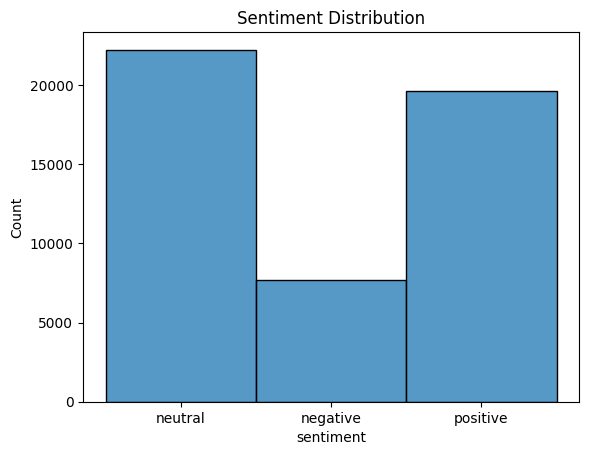

In [13]:
# Plot number of sentiments to get an idea of the distribution
plt.figure()
sns.histplot(data=tweets_df, x=tweets_df['sentiment'])
plt.title("Sentiment Distribution")

It can be observed that the dataset is imbalanced. Therefore, random undersampling will be performed during training to balance the dataset. 

Before anything else, let us begin preprocessing the dataset. As mentioned earlier, three different dataframes will receive different pre-processing functions. 
- (`preprocess_v1`) Did not remove following words after @ and #
- (`preprocess_v2`) Removed following words after @ and #
- (`preprocess_v3`) Used spaCy

The following will be done to preprocess the dataset:
1. Punctuations will be  removed.
2. Links will be removed.
3. `#` and `@` characters will also be removed from the texts, but the following word it will be retained. But the other dataframe will have the 
4. Numbers will be removed but numbers following letters (e.g. 2nd, 16th) will be retained

spaCy will be used to preprocess the other dataframe.

After cleaning the text, the following steps will be done (The spaCy package also performs this):
1. Words will be tokenized.
2. After tokenization, stop words will be removed.
3. Then lemmatization will be performed.  

In [13]:
# def clean_text_v1(text):
#     """
#     Removes @, #, and punctuation marks from the text.

#     Parameters:
#         text (str): tokenized tweet.
#     Returns:
#         str: The cleaned tweet text.
#     """
#     # Convert text to lowercase
#     text = text.lower()

#     # Regex pattern to match:
#     # 1. URLs starting with 'http' or 'https'
#     # 2. Characters that aren't word characters, whitespace, '@', or '#'
#     # 3. Individual '@' (mention indicator) and '#' (hashtag indicator) characters
#     # 4. Time patterns (e.g., '12:34')
#     # 5. Numbers not followed by a letter
#     # 6. Underscores
#     pattern = re.compile(r'(http|https)://[^\s]+|[^\w\s@#]|[@#]|\d+:\d+|\d+(?![a-zA-Z])|_')
#     cleaned_text = pattern.sub(' ', text)

#     # Remove extra spaces
#     cleaned_text = ' '.join(cleaned_text.split())
#     return cleaned_text

# def preprocess_text_v1(text):
#     """
#     Preprocesses the text.

#     Parameters:
#         text (str): tokenized tweet.
#     Returns:
#         str: The cleaned tweet text.
#     """
#     # Clean text
#     cleaned_text = clean_text_v1(text)
    
#     # Tokenize the text
#     words = word_tokenize(cleaned_text)
#     filtered_words = []
    
#     # Remove English Stop Words
#     stop_words = stopwords.words('English')
#     stop_words.remove("not")
#     stop_words = set(stop_words)
    
#     for word in words:
#         if word not in stop_words:
#             filtered_words.append(word)
#     # print("Filtered: ", filtered_words)
    
#     # Lemmatize the text for nouns
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_words = []
#     for word in filtered_words:
#         lemmatized_word = lemmatizer.lemmatize(word, pos='n')
#         lemmatized_words.append(lemmatized_word) 
#     # print("Lemmatized words:", lemmatized_words)

#     # Lemmatize for verbs
#     final_lemmatized_words = []
#     for word in lemmatized_words:
#         lemmatized_word = lemmatizer.lemmatize(word, pos='v')
#         final_lemmatized_words.append(lemmatized_word)
    
#     processed_text = ' '.join(final_lemmatized_words)
#     return processed_text


In [14]:
def clean_text_v2(text):
    """
    Removes @, #, and punctuation marks from the text.

    Parameters:
        text (str): tokenized tweet.
    Returns:
        str: The cleaned tweet text.
    """
    # Convert text to lowercase
    text = text.lower()

    # Regex pattern to match:
    # 1. URLs starting with 'http' or 'https'
    # 2. Characters that aren't word characters, whitespace, '@', or '#'
    # 3. Mentions (e.g., '@username') and hashtags (e.g., '#topic')
    # 4. Time patterns (e.g., '12:34')
    # 5. Numbers not followed by a letter
    # 6. Underscores
    pattern = re.compile(r'(http|https)://[^\s]+|[^\w\s@#]|(@\w+|#\w+)|\d+:\d+|\d+(?![a-zA-Z])|_')
    cleaned_text = pattern.sub(' ', text)

    

    # Remove extra spaces
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text

def preprocess_text_v2(text):
    """
    Preprocesses the text.

    Parameters:
        text (str): tokenized tweet.
    Returns:
        str: The cleaned tweet text.
    """
    # Clean text
    cleaned_text = clean_text_v2(text)
    
    # Tokenize the text
    words = word_tokenize(cleaned_text)
    filtered_words = []
    
    # Remove English Stop Words
    stop_words = stopwords.words('English')
    stop_words.remove("not")
    stop_words = set(stop_words)
    
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    # print("Filtered: ", filtered_words)
    
    # Lemmatize the text for nouns
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in filtered_words:
        lemmatized_word = lemmatizer.lemmatize(word, pos='n')
        lemmatized_words.append(lemmatized_word) 
    # print("Lemmatized words:", lemmatized_words)

    # Lemmatize for verbs
    final_lemmatized_words = []
    for word in lemmatized_words:
        lemmatized_word = lemmatizer.lemmatize(word, pos='v')
        final_lemmatized_words.append(lemmatized_word)
    
    processed_text = ' '.join(final_lemmatized_words)
    return processed_text


In [15]:
# import spacy

# def preprocess_text_v3(texts):
#     """
#     Preprocess a list of texts using spaCy for sentiment analysis.
#     This optimized version uses spaCy's pipe method for batch processing.
    
#     Parameters:
#         texts (list): List of original tweet texts.
    
#     Returns:
#         list: List of preprocessed texts.
#     """
#     # Load the spaCy model and disable parser, and named entity recognizer
#     nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
#     preprocessed_texts = []
    
#     # Use spaCy's pipe method for batch processing
#     for doc in nlp.pipe(texts, batch_size=50):
#         tokens = []
#         for token in doc:
#             if not (token.is_stop or token.is_punct):
#                 tokens.append(token.lemma_.lower())
#         preprocessed_texts.append(' '.join(tokens))
    
#     return preprocessed_texts


In [16]:
# print("Version 1:", preprocess_text_v1("7th 77 I am not happy, @william #blessed"))
print("Version 2:", preprocess_text_v2("7th 77 I am not happy, @william #blessed"))
# print("Version 3:", preprocess_text_v3(["7th 77 I am not happy, @william #blessed"]))

Version 1: 7th not happy william bless
Version 2: 7th not happy
Version 3: ['7th 77 happy @william bless']


In [16]:
# Copy DF apply different preprocessing techniques onto different dataframes
# preprocess_v1_tweets_df = tweets_df.copy()
preprocess_v2_tweets_df = tweets_df.copy()
# preprocess_v3_tweets_df = tweets_df.copy()

In [17]:
# Apply the preprocessing function to the tweet column of the DataFrame
# preprocess_v1_tweets_df['preprocessed_text'] = preprocess_v1_tweets_df['tweet'].apply(preprocess_text_v1)
# print("V1 Complete...")
preprocess_v2_tweets_df['preprocessed_text'] = preprocess_v2_tweets_df['tweet'].apply(preprocess_text_v2)
print("V2 Complete...")
# preprocess_v3_tweets_df['preprocessed_text'] = preprocess_text_v3(preprocess_v3_tweets_df["tweet"].tolist())
# print("V3 Complete...")

V2 Complete...


In [19]:
preprocess_v1_tweets_df.head()

,id,sentiment,tweet,preprocessed_text
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver...",match getin plus tomorrow busy day awareness d...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england could see first flake season ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,francesco con 2nd worst qb definitely tony rom...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,thailand washington u president barack obama v...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...,hear tony romo dress halloween giant quaterbac...


In [20]:
preprocess_v2_tweets_df.head()

,id,sentiment,tweet,preprocessed_text
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver...",match plus tomorrow busy day awareness day deb...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england could see first flake season ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,2nd worst qb definitely tony romo man like sha...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,washington u president barack obama vow wednes...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...,hear tony romo dress halloween giant quaterbac...


In [21]:
preprocess_v3_tweets_df.head()

,id,sentiment,tweet,preprocessed_text
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver...",won match getin plus tomorrow busy day awarene...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england flake season tuesday
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,@francesco_con40 2nd bad qb definitely tony ro...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,thailand washington president barack obama vow...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...,you hear tony romo dress halloween giants quat...


## Model Selection and Training

In [18]:
vectorizer = TfidfVectorizer(max_features=1000)
# matrix_v1 = vectorizer.fit_transform(preprocess_v1_tweets_df['preprocessed_text'])
matrix_v2 = vectorizer.fit_transform(preprocess_v2_tweets_df['preprocessed_text'])
# matrix_v3 = vectorizer.fit_transform(preprocess_v3_tweets_df['preprocessed_text'])
# Save the vectorizer
dump(vectorizer, '../models/vectorizer.joblib')
# print(matrix_v1)

['../models/vectorizer.joblib']

Sample run without undersampling.

In [23]:
features = matrix_v3

labels = preprocess_v3_tweets_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=77, test_size=0.2, shuffle=True)


In [24]:
svm = SVC(random_state=77, probability=True)
svm.fit(X_train, y_train)

predictions = svm.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.63      0.26      0.36      2325
     neutral       0.59      0.80      0.68      6676
    positive       0.71      0.60      0.65      5877

    accuracy                           0.63     14878
   macro avg       0.64      0.55      0.56     14878
weighted avg       0.65      0.63      0.62     14878



Let us see the performance after performing undersampling. 

In [26]:
# Display number of sentiments
labels.value_counts()

sentiment
neutral     22240
positive    19647
negative     7706
Name: count, dtype: int64

In [27]:
# Random Undersampler
rus = RandomUnderSampler(random_state=0)

# Declare features for each dataframe
features_v1 = matrix_v1
labels_v1 = preprocess_v1_tweets_df['sentiment']
features_v2 = matrix_v2
labels_v2 = preprocess_v2_tweets_df['sentiment']
features_v3 = matrix_v3
labels_v3 = preprocess_v3_tweets_df['sentiment']

X_res_v1, y_res_v1 = rus.fit_resample(features_v1, labels_v1)
X_res_v2, y_res_v2 = rus.fit_resample(features_v2, labels_v2)
X_res_v3, y_res_v3 = rus.fit_resample(features_v3, labels_v3)

print("After resampling v1: ", y_res_v1.value_counts())
print("After resampling v2: ", y_res_v2.value_counts())
print("After resampling v3: ", y_res_v3.value_counts())

X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_res_v1, y_res_v1, random_state=77, test_size=0.2, shuffle=True)
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_res_v2, y_res_v2, random_state=77, test_size=0.2, shuffle=True)
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_res_v3, y_res_v3, random_state=77, test_size=0.2, shuffle=True)

print("Training...")
svm_v1 = SVC(random_state=77, probability=True)
svm_v1.fit(X_train_v1, y_train_v1)
predictions_v1 = svm_v1.predict(X_test_v1)
print("V1 Done...")

svm_v2 = SVC(random_state=77, probability=True)
svm_v2.fit(X_train_v2, y_train_v2)
predictions_v2 = svm_v2.predict(X_test_v2)
print("V2 Done...")

svm_v3 = SVC(random_state=77, probability=True)
svm_v3.fit(X_train_v3, y_train_v3)
predictions_v3 = svm_v3.predict(X_test_v3)
print("V3 Done...")

print(classification_report(y_test_v1, predictions_v1))
print(classification_report(y_test_v2, predictions_v2))
print(classification_report(y_test_v3, predictions_v3))


After resampling v1:  sentiment
negative    7706
neutral     7706
positive    7706
Name: count, dtype: int64
After resampling v2:  sentiment
negative    7706
neutral     7706
positive    7706
Name: count, dtype: int64
After resampling v3:  sentiment
negative    7706
neutral     7706
positive    7706
Name: count, dtype: int64
Training...
V1 Done...
V2 Done...
V3 Done...
              precision    recall  f1-score   support

    negative       0.62      0.65      0.63      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624

              precision    recall  f1-score   support

    negative       0.62      0.65      0.64      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                 

The following are the results

### V1
```
              precision    recall  f1-score   support

    negative       0.62      0.65      0.63      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624

```

### V2 (remove following words )
```
              precision    recall  f1-score   support

    negative       0.62      0.65      0.64      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624
```

### V3 (spaCy)
```
              precision    recall  f1-score   support

    negative       0.62      0.64      0.63      1530
     neutral       0.53      0.57      0.55      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624
```


Since the other metrics have improved after balancing the dataset, let us try using other models

In [29]:
def train_predict(name, model, ver, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f"{name}_{ver}", classification_report(y_test, prediction))
    print('\n')
    dump(model, f"../models/{name}_model_{ver}.joblib")

# Initialize Models
svm = SVC(random_state=77, kernel='linear', probability=True)
dt = DecisionTreeClassifier(random_state=77)
rf = RandomForestClassifier(random_state=77)
nb = MultinomialNB()
models = {'SVM': svm, 'Decision Trees': dt,"Random Forest": rf, "Naive Bayes": nb}
trained_models = {}


for name, model in models.items():
    train_predict(name, model, "v1", X_train_v1, y_train_v1, X_test_v1, y_test_v1)
    train_predict(name, model, "v2", X_train_v2, y_train_v2, X_test_v2, y_test_v2)
    train_predict(name, model, "v3", X_train_v3, y_train_v3, X_test_v3, y_test_v3)
    print('\n')

SVM_v1               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.59      4624
   macro avg       0.59      0.59      0.59      4624
weighted avg       0.59      0.59      0.59      4624



SVM_v2               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.59      4624
   macro avg       0.60      0.59      0.59      4624
weighted avg       0.60      0.59      0.59      4624



SVM_v3               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.65      0.58      0.62      1

## SVM
```
SVM_v1               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.59      4624
   macro avg       0.59      0.59      0.59      4624
weighted avg       0.59      0.59      0.59      4624



SVM_v2               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.59      4624
   macro avg       0.60      0.59      0.59      4624
weighted avg       0.60      0.59      0.59      4624



SVM_v3               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.65      0.58      0.62      1546

    accuracy                           0.59      4624
   macro avg       0.60      0.59      0.59      4624
weighted avg       0.60      0.59      0.59      4624
```


## Decision Trees
```
Decision Trees_v1               precision    recall  f1-score   support

    negative       0.51      0.53      0.52      1530
     neutral       0.45      0.45      0.45      1548
    positive       0.54      0.52      0.53      1546

    accuracy                           0.50      4624
   macro avg       0.50      0.50      0.50      4624
weighted avg       0.50      0.50      0.50      4624



Decision Trees_v2               precision    recall  f1-score   support

    negative       0.52      0.54      0.53      1530
     neutral       0.46      0.44      0.45      1548
    positive       0.53      0.54      0.53      1546

    accuracy                           0.51      4624
   macro avg       0.50      0.51      0.50      4624
weighted avg       0.50      0.51      0.50      4624



Decision Trees_v3               precision    recall  f1-score   support

    negative       0.52      0.54      0.53      1530
     neutral       0.45      0.44      0.44      1548
    positive       0.52      0.51      0.52      1546

    accuracy                           0.50      4624
   macro avg       0.50      0.50      0.50      4624
weighted avg       0.50      0.50      0.50      4624
```


## Random Forest
```
Random Forest_v1               precision    recall  f1-score   support

    negative       0.59      0.64      0.61      1530
     neutral       0.51      0.53      0.52      1548
    positive       0.63      0.57      0.60      1546

    accuracy                           0.58      4624
   macro avg       0.58      0.58      0.58      4624
weighted avg       0.58      0.58      0.58      4624



Random Forest_v2               precision    recall  f1-score   support

    negative       0.59      0.64      0.61      1530
     neutral       0.52      0.51      0.51      1548
    positive       0.62      0.58      0.60      1546

    accuracy                           0.57      4624
   macro avg       0.57      0.57      0.57      4624
weighted avg       0.57      0.57      0.57      4624



Random Forest_v3               precision    recall  f1-score   support

    negative       0.61      0.62      0.62      1530
     neutral       0.50      0.53      0.52      1548
    positive       0.61      0.57      0.59      1546

    accuracy                           0.57      4624
   macro avg       0.58      0.58      0.58      4624
weighted avg       0.58      0.57      0.58      4624
```


## Naive Bayes
```
Naive Bayes_v1               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.47      0.49      1548
    positive       0.59      0.63      0.61      1546

    accuracy                           0.58      4624
   macro avg       0.57      0.58      0.57      4624
weighted avg       0.57      0.58      0.57      4624



Naive Bayes_v2               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.52      0.47      0.49      1548
    positive       0.59      0.63      0.61      1546

    accuracy                           0.58      4624
   macro avg       0.57      0.58      0.57      4624
weighted avg       0.57      0.58      0.57      4624



Naive Bayes_v3               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      1530
     neutral       0.54      0.51      0.52      1548
    positive       0.60      0.61      0.60      1546

    accuracy                           0.58      4624
   macro avg       0.58      0.58      0.58      4624
weighted avg       0.58      0.58      0.58      4624
```


- Looking at the weighted avg of the f1-scores, the SVM models (SVM_v1, SVM_v2, and SVM_v3) each have the highest score of 0.59.
- Among the SVM models, the difference in performance across the different preprocessing techniques (_v1, _v2, _v3) is very slight, with only minor differences in precision, recall, and f1-score across classes.
- This suggests that the preprocessing techniques employed for each version have similar impacts on the SVM model's performance.

## Preprocessing Performance

In [30]:
import time

# Generate sample data
texts = ["This is a sample text", "Another sample tweet", "More sample data for testing.. :)"]

iterations = 40  # number of iterations for averaging

# Measure average execution time for preprocess_text_v1
total_time = 0
for _ in range(iterations):
    start_time = time.time()
    for text in texts:
        preprocess_text_v1(text)
    end_time = time.time()
    total_time += (end_time - start_time)
average_time_v1 = total_time / iterations
print(f"Average execution time for preprocess_text_v1: {average_time_v1:.6f} seconds")

# Measure average execution time for preprocess_text_v2
total_time = 0
for _ in range(iterations):
    start_time = time.time()
    for text in texts:
        preprocess_text_v2(text)
    end_time = time.time()
    total_time += (end_time - start_time)
average_time_v2 = total_time / iterations
print(f"Average execution time for preprocess_text_v2: {average_time_v2:.6f} seconds")

# Measure average execution time for preprocess_text_v3
total_time = 0
for _ in range(iterations):
    start_time = time.time()
    preprocess_text_v3(texts)
    end_time = time.time()
    total_time += (end_time - start_time)
average_time_v3 = total_time / iterations
print(f"Average execution time for preprocess_text_v3: {average_time_v3:.6f} seconds")


Average execution time for preprocess_text_v1: 0.002426 seconds
Average execution time for preprocess_text_v2: 0.000997 seconds
Average execution time for preprocess_text_v3: 0.479347 seconds


Plotting the results

C:\Users\willi\AppData\Local\Temp\ipykernel_30260\1790270884.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Function', y='Average Execution Time', palette='viridis')
C:\Users\willi\AppData\Local\Temp\ipykernel_30260\1790270884.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results2_df, x='Function', y='Average Execution Time', palette='viridis')


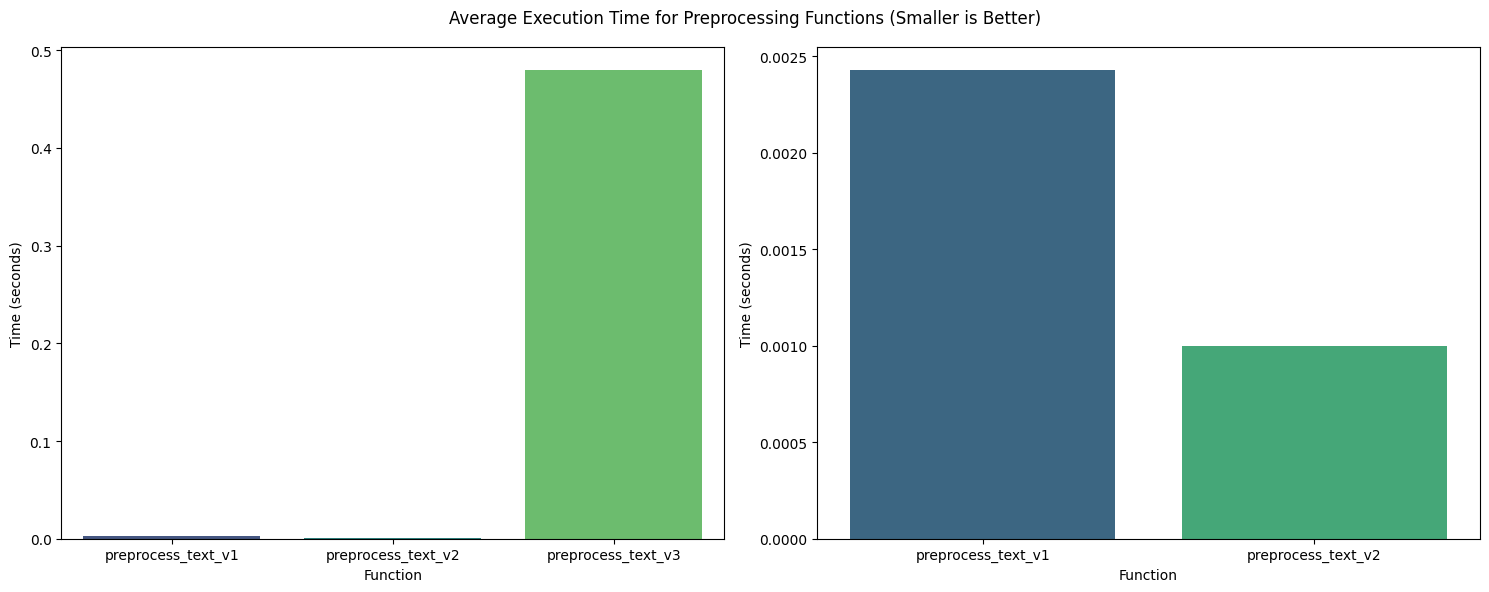

In [40]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame({'Function': ['preprocess_text_v1', 'preprocess_text_v2', 'preprocess_text_v3'],
                           'Average Execution Time':[average_time_v1, average_time_v2, average_time_v3]})

results2_df = pd.DataFrame({'Function': ['preprocess_text_v1', 'preprocess_text_v2'],
                           'Average Execution Time':[average_time_v1, average_time_v2]})

plt.figure(figsize=(15,6))

# First subplot for execution times
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st figure
sns.barplot(data=results_df, x='Function', y='Average Execution Time', palette='viridis')
plt.ylabel('Time (seconds)')
plt.tight_layout()

# Second subplot for the new variables
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd figure
sns.barplot(data=results2_df, x='Function', y='Average Execution Time', palette='viridis')
plt.ylabel('Time (seconds)')
plt.tight_layout()

plt.suptitle('Average Execution Time for Preprocessing Functions (Smaller is Better)')

plt.tight_layout()

# Save figure
# plt.savefig('avg_execution_times.png')

# Show plot
plt.show()

Looking at how the preprocessing techniques employed for each version have similar impacts, but the second version had the shortest execution time, the second function which removes the following words after `@` and `#` will be used.


Now, time for hyperparameter tuning, using `preprocess_text_v2` function.

## Hyperparameter Tuning

In [44]:
def preform_gridsearchcv(model_name, model, model_params, X_train, y_train):
    grid_search_model = GridSearchCV(model, model_params, cv=5)
    grid_search_model.fit(X_train, y_train)

    # Get best parameters
    best_params = grid_search_model.best_params_
    best_estimator = grid_search_model.best_estimator_
    print(f"{model_name} Best Parameters:")
    print(best_params)
    print(f"\n{model_name} Best Estimators:")
    print(best_estimator)


In [45]:
# Declare models again
svm = SVC(random_state=77, probability=True)
dt = DecisionTreeClassifier(random_state=77)
rf = RandomForestClassifier(random_state=77)
nb = MultinomialNB()

# Retraining with preprocess v2

In [ ]:
# Random Undersampler
rus = RandomUnderSampler(random_state=0)

# Declare features for each dataframe
features_v2 = matrix_v2
labels_v2 = preprocess_v2_tweets_df['sentiment']

X_res_v2, y_res_v2 = rus.fit_resample(features_v2, labels_v2)

print("After resampling v2: ", y_res_v2.value_counts())

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_res_v2, y_res_v2, random_state=77, test_size=0.2, shuffle=True)

In [46]:
# Naive Bayes Hyperparameter Tuning
naive_bayes_params = {'alpha': [0.1, 0.5, 1, 2]}
preform_gridsearchcv("Naive Bayes", nb, naive_bayes_params, X_train_v2, y_train_v2)

# SVM
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
preform_gridsearchcv("SVM", svm, svm_params, X_train_v2, y_train_v2)

# Decision Trees
decision_tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30, 40, 50]}
preform_gridsearchcv("Decision Trees", dt, decision_tree_params, X_train_v2, y_train_v2)

# Random Forest
random_forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30]}
preform_gridsearchcv("Random Forest", rf, random_forest_params, X_train_v2, y_train_v2)


Naive Bayes Best Parameters:
{'alpha': 2}

Naive Bayes Best Estimators:
MultinomialNB(alpha=2)
SVM Best Parameters:
{'C': 1, 'kernel': 'rbf'}

SVM Best Estimators:
SVC(C=1, probability=True, random_state=77)
Decision Trees Best Parameters:
{'criterion': 'gini', 'max_depth': 50}

Decision Trees Best Estimators:
DecisionTreeClassifier(max_depth=50, random_state=77)
Random Forest Best Parameters:
{'max_depth': None, 'n_estimators': 100}

Random Forest Best Estimators:
RandomForestClassifier(random_state=77)


Hypertuning results
```
Naive Bayes Best Parameters:
{'alpha': 2}

Naive Bayes Best Estimators:
MultinomialNB(alpha=2)


SVM Best Parameters:
{'C': 1, 'kernel': 'rbf'}

SVM Best Estimators:
SVC(C=1, probability=True, random_state=77)


Decision Trees Best Parameters:
{'criterion': 'gini', 'max_depth': 50}

Decision Trees Best Estimators:
DecisionTreeClassifier(max_depth=50, random_state=77)


Random Forest Best Parameters:
{'max_depth': None, 'n_estimators': 100}

Random Forest Best Estimators:
RandomForestClassifier(random_state=77)
```


In [20]:
print(y_train_v2.value_counts())

sentiment
negative    6176
positive    6160
neutral     6158
Name: count, dtype: int64


In [21]:
# Tuned
svm = SVC(C=1, kernel= 'rbf', random_state=77, probability=True)
dt = DecisionTreeClassifier(criterion= 'gini', max_depth= 50, random_state=77)
rf = RandomForestClassifier(max_depth= None, n_estimators=100, random_state=77)
nb = MultinomialNB(alpha=2)

models = {'SVM': svm, 'Decision Trees': dt,"Random Forest": rf, "Naive Bayes": nb}
trained_models = {}

for name, model in models.items():
    model.fit(X_train_v2, y_train_v2)
    prediction = model.predict(X_test_v2)
    print(f"{name}", classification_report(y_test_v2, prediction))
    print('\n')
    # Save the model
    dump(model, f"../models/tuned_{name}_model_v2.joblib")

SVM               precision    recall  f1-score   support

    negative       0.62      0.65      0.64      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624



Decision Trees               precision    recall  f1-score   support

    negative       0.56      0.46      0.50      1530
     neutral       0.44      0.62      0.52      1548
    positive       0.60      0.46      0.52      1546

    accuracy                           0.51      4624
   macro avg       0.53      0.51      0.51      4624
weighted avg       0.53      0.51      0.51      4624



Random Forest               precision    recall  f1-score   support

    negative       0.59      0.64      0.61      1530
     neutral       0.52      0.51      0.51      1548
    positive       0.62      0.58     

Tuned cells result

```
SVM               precision    recall  f1-score   support

    negative       0.62      0.65      0.64      1530
     neutral       0.52      0.56      0.54      1548
    positive       0.66      0.58      0.62      1546

    accuracy                           0.60      4624
   macro avg       0.60      0.60      0.60      4624
weighted avg       0.60      0.60      0.60      4624



Decision Trees    precision    recall  f1-score   support

    negative       0.56      0.46      0.50      1530
     neutral       0.44      0.62      0.52      1548
    positive       0.60      0.46      0.52      1546

    accuracy                           0.51      4624
   macro avg       0.53      0.51      0.51      4624
weighted avg       0.53      0.51      0.51      4624



Random Forest     precision    recall  f1-score   support

    negative       0.59      0.64      0.61      1530
     neutral       0.52      0.51      0.51      1548
    positive       0.62      0.58      0.60      1546

    accuracy                           0.57      4624
   macro avg       0.57      0.57      0.57      4624
weighted avg       0.57      0.57      0.57      4624



Naive Bayes        precision    recall  f1-score   support

    negative       0.60      0.64      0.62      1530
     neutral       0.52      0.46      0.49      1548
    positive       0.59      0.63      0.61      1546

    accuracy                           0.57      4624
   macro avg       0.57      0.57      0.57      4624
weighted avg       0.57      0.57      0.57      4624


```

# Testing with User Input

In [26]:
loaded_model = load('../models/tuned_SVM_model_v2.joblib')
vectorizer = load('../models/vectorizer.joblib')
user_input = "I am not happy"

cleaned_input = preprocess_text_v2(user_input)
print(cleaned_input)
user_input_tfidf = vectorizer.transform([cleaned_input])

predicted_label = loaded_model.predict(user_input_tfidf)

probability_estimates = loaded_model.predict_proba(user_input_tfidf)

print("Predicted Label:", predicted_label)
print("Probability Estimates:", probability_estimates)


not happy
Predicted Label: ['positive']
Probability Estimates: [[0.34474172 0.0297684  0.62548988]]
